## Evaluación de Modelos - Home Credit Default Risk

### Introducción

Una vez realizado el análisis exploratorio de datos y el preprocesamiento correspondiente, el siguiente paso clave es entrenar y evaluar diferentes modelos de machine learning para predecir el riesgo de incumplimiento por parte de los clientes. La variable objetivo (`TARGET`) indica si un cliente ha tenido dificultades para pagar su préstamo, y el objetivo de esta sección es construir modelos capaces de predecir correctamente este riesgo.

### Objetivos de esta etapa

1. **Implementar pipelines de entrenamiento**: Utilizar `Pipeline` de `scikit-learn` para estructurar el flujo de preprocesamiento y modelado, garantizando reproducibilidad y limpieza en el código.
2. **Entrenar múltiples modelos de clasificación**: Incluir algoritmos como regresión logística, árboles de decisión, Random Forest, XGBoost, LightGBM, MLPs personalizados (como el adaptador BCSCA) y compararlos bajo las mismas condiciones.
3. **Evaluar el desempeño de cada modelo**: Mediante métricas clave como AUC, accuracy, recall para la clase positiva (riesgo), precisión, F1-score, y curvas ROC.
4. **Identificar fortalezas y debilidades**: Detectar qué modelos tienen mayor capacidad para identificar correctamente a los clientes que no pagarán (clase 1) sin sacrificar demasiada precisión.
5. **Comparar resultados y seleccionar los mejores modelos**: No solo por su desempeño, sino también por su tiempo de entrenamiento y facilidad de implementación.

Este enfoque sistemático nos permitirá encontrar la mejor combinación de modelo y configuración para abordar el problema del riesgo de crédito en el contexto de los datos de Home Credit.


## Carga de datos

In [3]:
import pandas as pd
import numpy as np
import os

# Lista de archivos
archivos = {
    "train_final": "train_final.csv",
}

# Cargar archivos sin procesar, sin mostrar error si no existen
data = {}
for nombre, archivo in archivos.items():
    try:
        data[nombre] = pd.read_csv(archivo, low_memory=False)
    except FileNotFoundError:
        pass  # No muestra nada si no se encuentra el archivo


## Diccionario de datos

A continuación podrán observar el diccionario de los datos con los que vamos a trabajar.

In [5]:
import pandas as pd
import numpy as np
import os

# Intenta leer el archivo con diferentes codificaciones
try:
    description = pd.read_csv("HomeCredit_Columns_description.csv", encoding="utf-8")
except UnicodeDecodeError:
    description = pd.read_csv("HomeCredit_Columns_description.csv", encoding="ISO-8859-1")  # Alternativa

# Extraer train_final
train_final = data["train_final"]

# Extraer las variables únicas de train_final en un DataFrame
train_variables = pd.DataFrame(train_final.columns, columns=["Row"]).drop_duplicates()

# Eliminar duplicados en el DataFrame de descripciones para evitar repetición de variables
description_cleaned = description[['Row', 'Description']].drop_duplicates()

# Cruzar con el DataFrame de descripciones
merged_df = train_variables.merge(description_cleaned, on="Row", how="left")

# Configurar Pandas para mostrar toda la tabla sin truncamientos
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.max_colwidth', None)  # Evitar que se corte el texto en columnas largas
pd.set_option('display.expand_frame_repr', False)  # Evita que las columnas se dividan en varias líneas

# Mostrar la tabla completa en Jupyter Notebook
from IPython.display import display
display(merged_df)


,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,NaN
2,NAME_CONTRACT_TYPE_x,NaN
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
5,FLAG_OWN_REALTY,Flag if client owns a house or flat
6,CNT_CHILDREN,Number of children the client has
7,AMT_INCOME_TOTAL,Income of the client
8,AMT_CREDIT_x,NaN
9,AMT_ANNUITY_x,NaN


# Limpieza de datos

In [5]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, roc_auc_score, precision_score,
    recall_score, f1_score, accuracy_score
)
from imblearn.over_sampling import SMOTE
from scipy.stats import ttest_ind


In [7]:
# --- Paso 1: Selección de variables ---
selected_columns = [
    'TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'AMT_INCOME_TOTAL',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE',
    'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
    'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'NAME_PRODUCT_TYPE', 'NAME_YIELD_GROUP'
]

df_filtered = train_final[selected_columns].copy()
X = df_filtered.drop(columns='TARGET')
y = df_filtered['TARGET']

In [9]:
# --- Paso 2: División ---
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)


In [11]:

# --- Paso 3: Preprocesamiento ---
numeric_features = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'AMT_INCOME_TOTAL',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE',
    'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'
]

categorical_features = [
    'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 
    'NAME_PRODUCT_TYPE', 'NAME_YIELD_GROUP'
]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Despliegue de modelos

### Función para mostrar resultados

In [13]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import wilcoxon

def imprimir_resultados_clasificacion(
    y_true, y_pred, y_proba, tiempo,
    y_train_true=None, y_train_pred=None,
    y_test_true=None, y_test_pred=None
):
    # Reporte
    reporte = classification_report(y_true, y_pred, target_names=['Clase 0', 'Clase 1'], output_dict=True)
    matriz = confusion_matrix(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    # -------------------------------
    # GRÁFICO: MATRIZ DE CONFUSIÓN
    plt.figure(figsize=(5, 4))
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title('🧮 Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

    # -------------------------------
    # GRÁFICO: CURVA ROC
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title('📈 Curva ROC')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend()
    plt.grid()
    plt.show()

    # -------------------------------
    # IMPRESIÓN DE MÉTRICAS
    print("="*50)
    print("🔍 RESUMEN DE DESEMPEÑO DEL MODELO".center(50))
    print("="*50)
    print(f"⏱️  Tiempo de ejecución total: {tiempo:.2f} segundos\n")

    print("📊 MÉTRICAS GLOBALES:")
    print(f"   - Accuracy:        {reporte['accuracy']:.3f}")
    print(f"   - Recall (Clase 1):{reporte['Clase 1']['recall']:.3f}")
    print(f"   - Precision (Clase 1): {reporte['Clase 1']['precision']:.3f}")
    print(f"   - F1-score (Clase 1):  {reporte['Clase 1']['f1-score']:.3f}")
    print(f"   - AUC:             {auc:.3f}\n")

    print("📌 DESEMPEÑO POR CLASE:")
    for clase in ['Clase 0', 'Clase 1']:
        print(f"  ▸ {clase}")
        print(f"     - Precision: {reporte[clase]['precision']:.3f}")
        print(f"     - Recall:    {reporte[clase]['recall']:.3f}")
        print(f"     - F1-score:  {reporte[clase]['f1-score']:.3f}")

    print("🧮 MATRIZ DE CONFUSIÓN:")
    print(f"         Pred 0    Pred 1")
    print(f"True 0   {matriz[0, 0]:7d}   {matriz[0, 1]:7d}")
    print(f"True 1   {matriz[1, 0]:7d}   {matriz[1, 1]:7d}")
    print("="*50)

    # -------------------------------
    # WILCOXON + RECALL TRAIN Y TEST
    if y_train_true is not None and y_train_pred is not None and y_test_true is not None and y_test_pred is not None:
        recall_train = recall_score(y_train_true, y_train_pred, pos_label=1)
        recall_test  = recall_score(y_test_true,  y_test_pred,  pos_label=1)

        print(f"\n🎯 RECALL Clase 1:")
        print(f"   - Entrenamiento: {recall_train:.4f}")
        print(f"   - Prueba:        {recall_test:.4f}")

        # Muestras binarias para Wilcoxon
        tp_train = ((y_train_true == 1) & (y_train_pred == 1)).astype(int)
        tp_test = ((y_test_true == 1) & (y_test_pred == 1)).astype(int)
        min_len = min(len(tp_train), len(tp_test))

        stat, pval = wilcoxon(tp_train[:min_len], tp_test[:min_len])

        print(f"\n🧪 Test de Wilcoxon (recall train vs test):")
        print(f"   - z = {stat:.4f}")
        print(f"   - p-valor = {pval:.4f}")
        print("="*50)


## Modelo de regresión logística con penalización L1 Y L2

In [15]:
from sklearn.model_selection import train_test_split

# Fracción del 20% del train_val para acelerar el GridSearch
X_subsample, _, y_subsample, _ = train_test_split(
    X_train_val, y_train_val, test_size=0.8, stratify=y_train_val, random_state=42
)

# Pipeline con penalización L2 y solver saga
pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(penalty='l2', solver='liblinear', max_iter=300))
])

param_grid = {
    'clf__C': [0.1, 1]
}

# GridSearch con recall y subsample
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='recall',
    n_jobs=1
)

print("⏳ Entrenando GridSearchCV con subsample del 20%...")
start_time = time.time()
grid.fit(X_subsample, y_subsample)
end_time = time.time()
print(f"✅ Entrenamiento completado en {end_time - start_time:.2f} segundos")

# Mostrar los mejores parámetros encontrados
print("🧠 Mejores parámetros encontrados:")
print(grid.best_params_)
print(f"🎯 Mejor recall en validación: {grid.best_score_:.4f}")


⏳ Entrenando GridSearchCV con subsample del 20%...
✅ Entrenamiento completado en 20.39 segundos
🧠 Mejores parámetros encontrados:
{'clf__C': 1}
🎯 Mejor recall en validación: 0.6523


In [17]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import time

# Pipeline L2 usando el mejor C encontrado antes
pipeline_l2 = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(penalty='l2', C=1, solver='liblinear', max_iter=300))
])

# Entrenamiento
start_time_l2 = time.time()
pipeline_l2.fit(X_train_val, y_train_val)
end_time_l2 = time.time()
tiempo_l2 = end_time_l2 - start_time_l2

# Predicciones
y_test_pred_l2 = pipeline_l2.predict(X_test)
y_test_proba_l2 = pipeline_l2.predict_proba(X_test)[:, 1]
y_train_pred_l2 = pipeline_l2.predict(X_train_val)

📌 Evaluación Modelo: Regresión Logística L2



C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


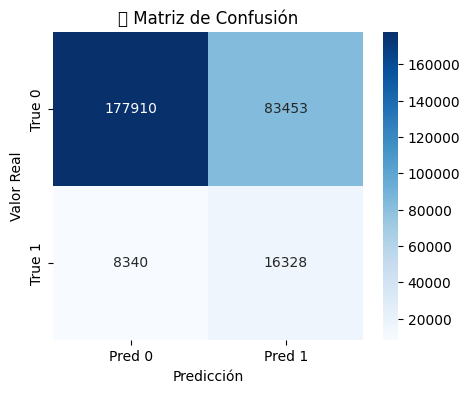

C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


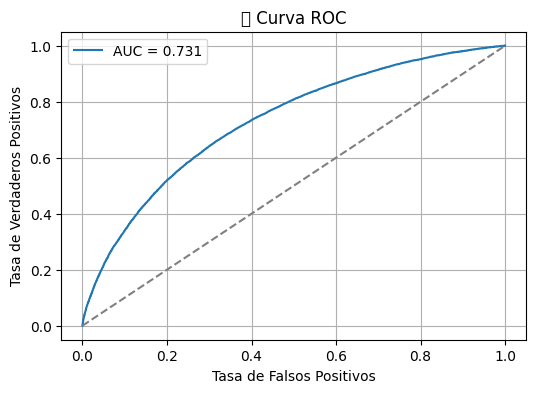

        🔍 RESUMEN DE DESEMPEÑO DEL MODELO         
⏱️  Tiempo de ejecución total: 38.63 segundos

📊 MÉTRICAS GLOBALES:
   - Accuracy:        0.679
   - Recall (Clase 1):0.662
   - Precision (Clase 1): 0.164
   - F1-score (Clase 1):  0.262
   - AUC:             0.731

📌 DESEMPEÑO POR CLASE:
  ▸ Clase 0
     - Precision: 0.955
     - Recall:    0.681
     - F1-score:  0.795
  ▸ Clase 1
     - Precision: 0.164
     - Recall:    0.662
     - F1-score:  0.262
🧮 MATRIZ DE CONFUSIÓN:
         Pred 0    Pred 1
True 0    177910     83453
True 1      8340     16328

🎯 RECALL Clase 1:
   - Entrenamiento: 0.6603
   - Prueba:        0.6619

🧪 Test de Wilcoxon (recall train vs test):
   - z = 235675155.5000
   - p-valor = 0.4586


In [19]:
# Evaluación con función extendida
print("📌 Evaluación Modelo: Regresión Logística L2\n")
imprimir_resultados_clasificacion(
    y_test, y_test_pred_l2, y_test_proba_l2, tiempo_l2,
    y_train_true=y_train_val,
    y_train_pred=y_train_pred_l2,
    y_test_true=y_test,
    y_test_pred=y_test_pred_l2
)

In [21]:
from sklearn.linear_model import LogisticRegression

# Pipeline L1 usando el mejor C encontrado antes
pipeline_l1 = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(penalty='l1', C=1, solver='liblinear', max_iter=300))
])

# Entrenamiento
start_time_l1 = time.time()
pipeline_l1.fit(X_train_val, y_train_val)
end_time_l1 = time.time()
tiempo_l1 = end_time_l1 - start_time_l1

# Predicciones
y_test_pred_l1 = pipeline_l1.predict(X_test)
y_test_proba_l1 = pipeline_l1.predict_proba(X_test)[:, 1]
y_train_pred_l1 = pipeline_l1.predict(X_train_val)

📌 Evaluación Modelo: Regresión Logística L1



C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


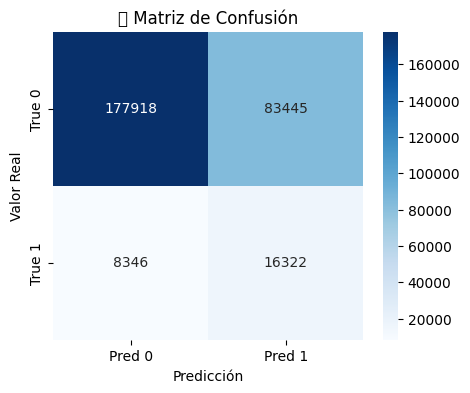

C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


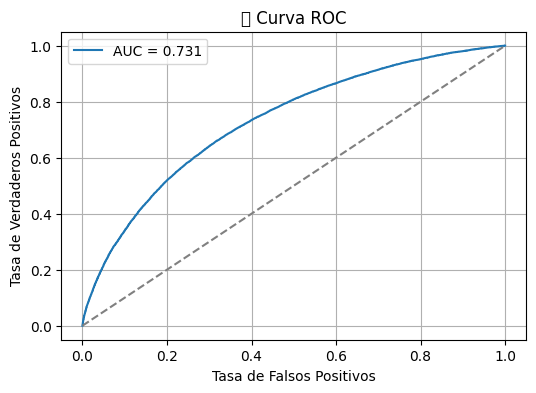

        🔍 RESUMEN DE DESEMPEÑO DEL MODELO         
⏱️  Tiempo de ejecución total: 64.47 segundos

📊 MÉTRICAS GLOBALES:
   - Accuracy:        0.679
   - Recall (Clase 1):0.662
   - Precision (Clase 1): 0.164
   - F1-score (Clase 1):  0.262
   - AUC:             0.731

📌 DESEMPEÑO POR CLASE:
  ▸ Clase 0
     - Precision: 0.955
     - Recall:    0.681
     - F1-score:  0.795
  ▸ Clase 1
     - Precision: 0.164
     - Recall:    0.662
     - F1-score:  0.262
🧮 MATRIZ DE CONFUSIÓN:
         Pred 0    Pred 1
True 0    177918     83445
True 1      8346     16322

🎯 RECALL Clase 1:
   - Entrenamiento: 0.6604
   - Prueba:        0.6617

🧪 Test de Wilcoxon (recall train vs test):
   - z = 235744416.0000
   - p-valor = 0.4975


In [23]:
# Evaluación con función extendida
print("📌 Evaluación Modelo: Regresión Logística L1\n")
imprimir_resultados_clasificacion(
    y_test, y_test_pred_l1, y_test_proba_l1, tiempo_l1,
    y_train_true=y_train_val,
    y_train_pred=y_train_pred_l1,
    y_test_true=y_test,
    y_test_pred=y_test_pred_l1
)

## Modelo de clasificación Naive Bayes

In [31]:
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline as ImbPipeline
import time

# 🧪 Pipeline con GaussianNB
pipeline_nb = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', GaussianNB())
])

# 🚀 Entrenamiento
start_time_nb = time.time()
pipeline_nb.fit(X_train_val, y_train_val)
end_time_nb = time.time()
tiempo_nb = end_time_nb - start_time_nb

# 🔮 Predicciones
y_test_pred_nb = pipeline_nb.predict(X_test)
y_test_proba_nb = pipeline_nb.predict_proba(X_test)[:, 1]
y_train_pred_nb = pipeline_nb.predict(X_train_val)

📌 Evaluación Modelo: Naive Bayes



C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


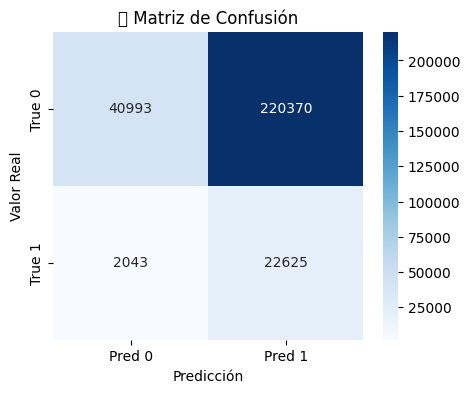

C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


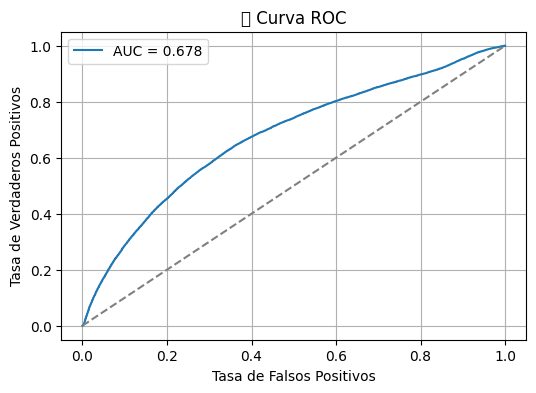

        🔍 RESUMEN DE DESEMPEÑO DEL MODELO         
⏱️  Tiempo de ejecución total: 24.66 segundos

📊 MÉTRICAS GLOBALES:
   - Accuracy:        0.222
   - Recall (Clase 1):0.917
   - Precision (Clase 1): 0.093
   - F1-score (Clase 1):  0.169
   - AUC:             0.678

📌 DESEMPEÑO POR CLASE:
  ▸ Clase 0
     - Precision: 0.953
     - Recall:    0.157
     - F1-score:  0.269
     - Soporte:   261363

  ▸ Clase 1
     - Precision: 0.093
     - Recall:    0.917
     - F1-score:  0.169
     - Soporte:   24668

🧮 MATRIZ DE CONFUSIÓN:
         Pred 0    Pred 1
True 0     40993    220370
True 1      2043     22625

🎯 RECALL Clase 1:
   - Entrenamiento: 0.9178
   - Prueba:        0.9172

🧪 Test de Wilcoxon (recall train vs test):
   - z = 428289621.0000
   - p-valor = 0.2311


In [33]:
# Evaluación con función extendida
print("📌 Evaluación Modelo: Naive Bayes\n")
imprimir_resultados_clasificacion(
    y_test, y_test_pred_nb, y_test_proba_nb, tiempo_nb,
    y_train_true=y_train_val,
    y_train_pred=y_train_pred_nb,
    y_test_true=y_test,
    y_test_pred=y_test_pred_nb
)

## Modelo de clasificación Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    recall_score, precision_score, f1_score,
    accuracy_score, roc_auc_score
)
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
import time

from sklearn.metrics import make_scorer, recall_score

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    recall_score, precision_score, f1_score,
    accuracy_score, roc_auc_score
)
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
import time

from sklearn.metrics import make_scorer, recall_score

# Scorer personalizado para enfocar el grid en recall clase 1
scorer_recall_clase1 = make_scorer(recall_score, pos_label=1)


# 🧪 Submuestreo del 5% para GridSearchCV
X_sampled_rf, _, y_sampled_rf, _ = train_test_split(
    X_train_val, y_train_val, train_size=0.05, stratify=y_train_val, random_state=42
)

# Pipeline con Random Forest
pipeline_rf = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

# GridSearch muy acotado
param_grid_rf = {
    'clf__n_estimators': [200],
    'clf__max_depth': [5, 10],
}

grid_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    cv=3,
    scoring=scorer_recall_clase1,
    n_jobs=1
)

# 🚀 GridSearchCV en el subset
grid_rf.fit(X_sampled_rf, y_sampled_rf)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['EXT_SOURCE_1',
                                                                          'EXT_SOURCE_2',
                                                                          'EXT_SOURCE_3',
                                                                          'AMT_CREDIT_x',
                                                                          'AMT_ANNUITY_x',
                                                                          'AMT_GOODS_PRICE_x',
                                                                          'AMT_INCOME_TOTAL',
                                                                          'DAYS_BIRTH',
                                                                          'DAYS_EMPLOYED',
                                                                          'DAYS_LAST_PHO...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['NAME_CONTRACT_TYPE_x',
                                                                          'CODE_GENDER',
                                                                          'NAME_PRODUCT_TYPE',
                                                                          'NAME_YIELD_GROUP'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=1,
             param_grid={'clf__max_depth': [5, 10], 'clf__n_estimators': [200]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=1))

In [41]:
mejores_rf = grid_rf.best_params_

In [43]:
print(mejores_rf)

{'clf__max_depth': 5, 'clf__n_estimators': 200}


In [33]:

modelo_final_rf = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

start_time_rf = time.time()
modelo_final_rf.fit(X_train_val, y_train_val)
end_time_rf = time.time()
tiempo_rf = end_time_rf - start_time_rf

# ------------------------------------------
# 🔮 Predicciones
y_test_pred_rf = modelo_final_rf.predict(X_test)
y_test_proba_rf = modelo_final_rf.predict_proba(X_test)[:, 1]
y_train_pred_rf = modelo_final_rf.predict(X_train_val)

📌 Evaluación Modelo: Random Forest



C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


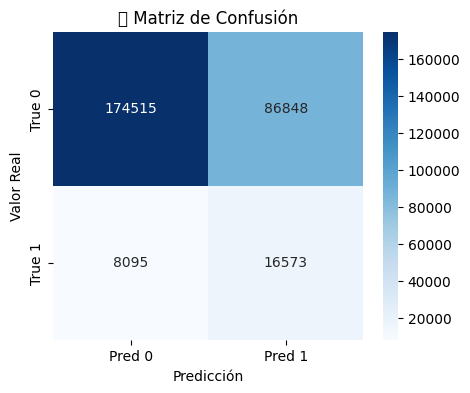

C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


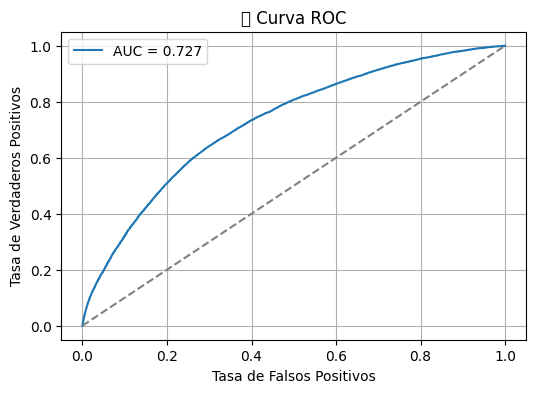

        🔍 RESUMEN DE DESEMPEÑO DEL MODELO         
⏱️  Tiempo de ejecución total: 107.96 segundos

📊 MÉTRICAS GLOBALES:
   - Accuracy:        0.668
   - Recall (Clase 1):0.672
   - Precision (Clase 1): 0.160
   - F1-score (Clase 1):  0.259
   - AUC:             0.727

📌 DESEMPEÑO POR CLASE:
  ▸ Clase 0
     - Precision: 0.956
     - Recall:    0.668
     - F1-score:  0.786
  ▸ Clase 1
     - Precision: 0.160
     - Recall:    0.672
     - F1-score:  0.259
🧮 MATRIZ DE CONFUSIÓN:
         Pred 0    Pred 1
True 0    174515     86848
True 1      8095     16573

🎯 RECALL Clase 1:
   - Entrenamiento: 0.6719
   - Prueba:        0.6718

🧪 Test de Wilcoxon (recall train vs test):
   - z = 241653177.5000
   - p-valor = 0.3648


In [35]:
# Evaluación con función extendida
print("📌 Evaluación Modelo: Random Forest\n")
imprimir_resultados_clasificacion(
    y_test, y_test_pred_rf, y_test_proba_rf, tiempo_rf,
    y_train_true=y_train_val,
    y_train_pred=y_train_pred_rf,
    y_test_true=y_test,
    y_test_pred=y_test_pred_rf
)

## Modelo de clasificación XGBoost

In [37]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
import time


In [39]:
!nvidia-smi

Mon May 19 09:34:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.07                 Driver Version: 566.07         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8              6W /   60W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [47]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, recall_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Subset de datos para hacer GridSearch más rápido
X_sampled_xgb, _, y_sampled_xgb, _ = train_test_split(
    X_train_val, y_train_val, train_size=0.05, stratify=y_train_val, random_state=42
)

In [49]:
from xgboost import XGBClassifier

pipeline_xgb = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        device='cuda',  # Nuevo método oficial
        random_state=42
    ))
])


param_grid_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.1]
}

cv_xgb = 5

grid_xgb = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid_xgb,
    cv=cv_xgb,
    scoring='recall',
    n_jobs=1
)

grid_xgb.fit(X_sampled_xgb, y_sampled_xgb)


C:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:729: UserWarning: [09:39:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['EXT_SOURCE_1',
                                                                          'EXT_SOURCE_2',
                                                                          'EXT_SOURCE_3',
                                                                          'AMT_CREDIT_x',
                                                                          'AMT_ANNUITY_x',
                                                                          'AMT_GOODS_PRICE_x',
                                                                          'AMT_INCOME_TOTAL',
                                                                          'DAYS_BIRTH',
                                                                          'DAYS_EMPLOYED',
                                                                          'DAYS_LAST_PHO...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=1,
             param_grid={'clf__learning_rate': [0.1], 'clf__max_depth': [3, 5],
                         'clf__n_estimators': [100, 200]},
             scoring='recall')

In [55]:
mejores_xgb = grid_xgb.best_params_

modelo_final_xgb = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(
        n_estimators=mejores_xgb['clf__n_estimators'],
        max_depth=mejores_xgb['clf__max_depth'],
        learning_rate=mejores_xgb['clf__learning_rate'],
        objective='binary:logistic',
        eval_metric='logloss',
        device='cuda',  # ✅ Nuevo parámetro oficial para GPU
        random_state=42
    ))
])


In [57]:
start_time_xgb = time.time()
modelo_final_xgb.fit(X_train_val, y_train_val)
end_time_xgb = time.time()
tiempo_xgb = end_time_xgb - start_time_xgb

# Predicciones
y_test_pred_xgb = modelo_final_xgb.predict(X_test)
y_test_proba_xgb = modelo_final_xgb.predict_proba(X_test)[:, 1]
y_train_pred_xgb = modelo_final_xgb.predict(X_train_val)

C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


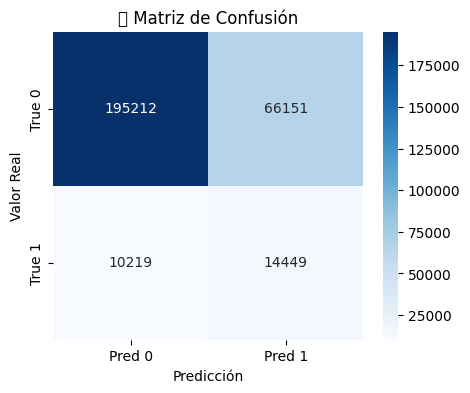

C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


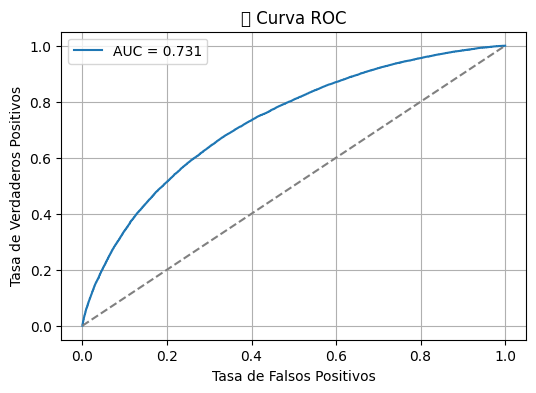

        🔍 RESUMEN DE DESEMPEÑO DEL MODELO         
⏱️  Tiempo de ejecución total: 23.56 segundos

📊 MÉTRICAS GLOBALES:
   - Accuracy:        0.733
   - Recall (Clase 1):0.586
   - Precision (Clase 1): 0.179
   - F1-score (Clase 1):  0.275
   - AUC:             0.731

📌 DESEMPEÑO POR CLASE:
  ▸ Clase 0
     - Precision: 0.950
     - Recall:    0.747
     - F1-score:  0.836
  ▸ Clase 1
     - Precision: 0.179
     - Recall:    0.586
     - F1-score:  0.275
🧮 MATRIZ DE CONFUSIÓN:
         Pred 0    Pred 1
True 0    195212     66151
True 1     10219     14449

🎯 RECALL Clase 1:
   - Entrenamiento: 0.5841
   - Prueba:        0.5857

🧪 Test de Wilcoxon (recall train vs test):
   - z = 185358420.0000
   - p-valor = 0.1873


In [59]:
# Evaluación completa con gráfica, AUC, Wilcoxon
imprimir_resultados_clasificacion(
    y_test, y_test_pred_xgb, y_test_proba_xgb, tiempo_xgb,
    y_train_true=y_train_val,
    y_train_pred=y_train_pred_xgb,
    y_test_true=y_test,
    y_test_pred=y_test_pred_xgb
)

## Modelo de clasificación SVM

In [39]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
import time

In [41]:
X_sampled_sgd, _, y_sampled_sgd, _ = train_test_split(
    X_train_val, y_train_val, train_size=0.05, stratify=y_train_val, random_state=42
)

In [43]:
scorer_recall_clase1 = make_scorer(recall_score, pos_label=1)

In [45]:
modelo_svm = SGDClassifier(
    loss='hinge',
    penalty='l2',
    max_iter=1000,
    tol=1e-3,
    random_state=42,
    n_jobs=-1
)

pipeline_svm = ImbPipeline([
    ('preprocessing', preprocessor),
    ('balanceo', SMOTE(random_state=42)),
    ('classifier', modelo_svm)
])

param_grid_svm = {
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__penalty': ['l2', 'elasticnet']
}

cv_svm = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_svm = GridSearchCV(
    estimator=pipeline_svm,
    param_grid=param_grid_svm,
    cv=cv_svm,
    scoring=scorer_recall_clase1,
    n_jobs=1
)

grid_svm.fit(X_sampled_sgd, y_sampled_sgd)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['EXT_SOURCE_1',
                                                                          'EXT_SOURCE_2',
                                                                          'EXT_SOURCE_3',
                                                                          'AMT_CREDIT_x',
                                                                          'AMT_ANNUITY_x',
                                                                          'AMT_GOODS_PRICE_x',
                                                                          'AMT_IN...
                                                                         ['NAME_CONTRACT_TYPE_x',
                                                                          'CODE_GENDER',
                                                                          'NAME_PRODUCT_TYPE',
                                                                          'NAME_YIELD_GROUP'])])),
                                       ('balanceo', SMOTE(random_state=42)),
                                       ('classifier',
                                        SGDClassifier(n_jobs=-1,
                                                      random_state=42))]),
             n_jobs=1,
             param_grid={'classifier__alpha': [0.0001, 0.001, 0.01],
                         'classifier__penalty': ['l2', 'elasticnet']},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=1))

In [47]:
mejores_svm = grid_svm.best_params_

modelo_final_svm = ImbPipeline([
    ('preprocessing', preprocessor),
    ('balanceo', SMOTE(random_state=42)),
    ('classifier', SGDClassifier(
        loss='hinge',
        alpha=mejores_svm['classifier__alpha'],
        penalty=mejores_svm['classifier__penalty'],
        max_iter=1000,
        tol=1e-3,
        random_state=42,
        n_jobs=-1
    ))
])

start_time_svm = time.time()
modelo_final_svm.fit(X_train_val, y_train_val)
end_time_svm = time.time()
tiempo_svm = end_time_svm - start_time_svm


In [79]:
y_test_pred_svm = modelo_final_svm.predict(X_test)
y_test_proba_svm = modelo_final_svm.decision_function(X_test)
y_train_pred_svm = modelo_final_svm.predict(X_train_val)

C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


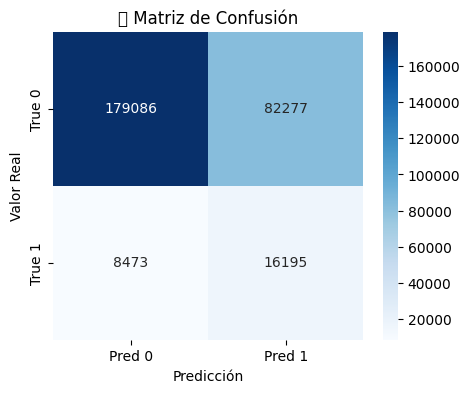

C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


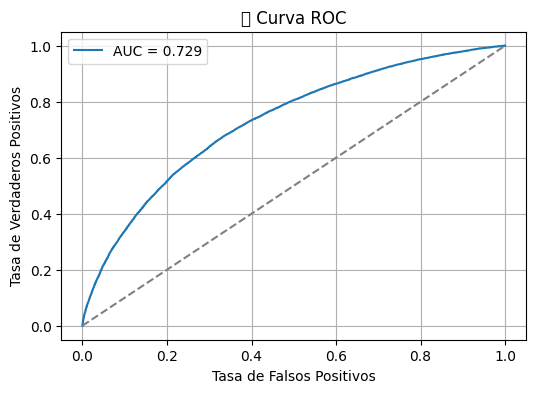

        🔍 RESUMEN DE DESEMPEÑO DEL MODELO         
⏱️  Tiempo de ejecución total: 28.48 segundos

📊 MÉTRICAS GLOBALES:
   - Accuracy:        0.683
   - Recall (Clase 1):0.657
   - Precision (Clase 1): 0.164
   - F1-score (Clase 1):  0.263
   - AUC:             0.729

📌 DESEMPEÑO POR CLASE:
  ▸ Clase 0
     - Precision: 0.955
     - Recall:    0.685
     - F1-score:  0.798
     - Soporte:   261363

  ▸ Clase 1
     - Precision: 0.164
     - Recall:    0.657
     - F1-score:  0.263
     - Soporte:   24668

🧮 MATRIZ DE CONFUSIÓN:
         Pred 0    Pred 1
True 0    179086     82277
True 1      8473     16195

🎯 RECALL Clase 1:
   - Entrenamiento: 0.6552
   - Prueba:        0.6565

🧪 Test de Wilcoxon (recall train vs test):
   - z = 231045815.0000
   - p-valor = 0.3359


In [81]:
# Evaluación completa con gráfica, AUC, Wilcoxon
imprimir_resultados_clasificacion(
    y_test, y_test_pred_svm, y_test_proba_svm, tiempo_svm,
    y_train_true=y_train_val,
    y_train_pred=y_train_pred_svm,
    y_test_true=y_test,
    y_test_pred=y_test_pred_svm
)

## Propuesta Modelo Original con LightGBM

In [19]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
from sklearn.pipeline import Pipeline
from sklearn.utils import compute_class_weight

# ----------------------------
# Subsample de datos
X_sampled_lgbm, _, y_sampled_lgbm, _ = train_test_split(
    X_train_val, y_train_val, train_size=0.05, stratify=y_train_val, random_state=42
)

# ----------------------------
# Ponderación automática de clase 1 (morosos)
peso_clase = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_sampled_lgbm
)
peso_clase_1 = peso_clase[1]

# ----------------------------
# Scorer enfocado en Recall de morosos
scorer_recall = make_scorer(recall_score, pos_label=1)

# ----------------------------
# Pipeline simple sin SMOTE (para velocidad)
pipeline_lgbm = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('clf', LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        scale_pos_weight=peso_clase_1,
        boosting_type='gbdt',
        random_state=42,
        verbose=-1,
        n_jobs=-1
    ))
])

# ----------------------------
# Grid de parámetros compacto
param_grid_lgbm = {
    'clf__n_estimators': [100],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.05, 0.1],
    'clf__num_leaves': [15, 31]
}

# ----------------------------
# GridSearchCV rápido
grid_lgbm = GridSearchCV(
    estimator=pipeline_lgbm,
    param_grid=param_grid_lgbm,
    cv=3,
    scoring=scorer_recall,
    verbose=2,
    n_jobs=-1
)

# ----------------------------
# Entrenar
grid_lgbm.fit(X_sampled_lgbm, y_sampled_lgbm)
print("✅ Mejores parámetros encontrados:")
print(grid_lgbm.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Mejores parámetros encontrados:
{'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 100, 'clf__num_leaves': 15}


In [25]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

modelo_final_lgbm = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('clf', LGBMClassifier(
        learning_rate=0.1,
        max_depth=5,
        n_estimators=100,
        num_leaves=15,
        scale_pos_weight=peso_clase_1,
        objective='binary',
        metric='binary_logloss',
        boosting_type='gbdt',
        verbose=-1,
        n_jobs=-1,
        random_state=42
    ))
])

start_time_lgbm = time.time()
modelo_final_lgbm.fit(X_train_val, y_train_val)
end_time_lgbm = time.time()
tiempo_lgbm = end_time_lgbm - start_time_lgbm

In [27]:
# Predicciones
y_test_pred = modelo_final_lgbm.predict(X_test)
y_test_proba = modelo_final_lgbm.predict_proba(X_test)[:, 1]
y_train_pred = modelo_final_lgbm.predict(X_train_val)

C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


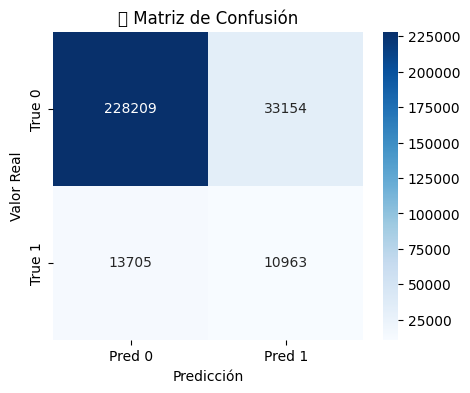

C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


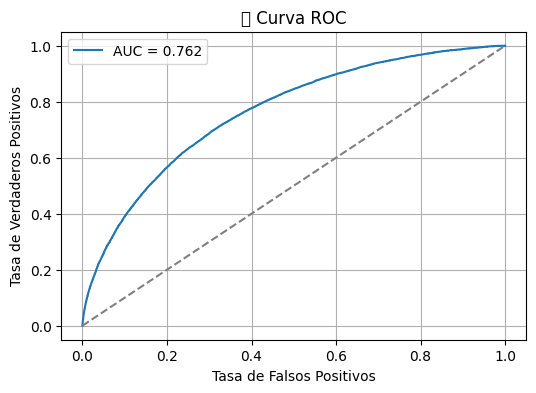

        🔍 RESUMEN DE DESEMPEÑO DEL MODELO         
⏱️  Tiempo de ejecución total: 6.83 segundos

📊 MÉTRICAS GLOBALES:
   - Accuracy:        0.836
   - Recall (Clase 1):0.444
   - Precision (Clase 1): 0.248
   - F1-score (Clase 1):  0.319
   - AUC:             0.762

📌 DESEMPEÑO POR CLASE:
  ▸ Clase 0
     - Precision: 0.943
     - Recall:    0.873
     - F1-score:  0.907
  ▸ Clase 1
     - Precision: 0.248
     - Recall:    0.444
     - F1-score:  0.319
🧮 MATRIZ DE CONFUSIÓN:
         Pred 0    Pred 1
True 0    228209     33154
True 1     13705     10963

🎯 RECALL Clase 1:
   - Entrenamiento: 0.4478
   - Prueba:        0.4444

🧪 Test de Wilcoxon (recall train vs test):
   - z = 109614780.0000
   - p-valor = 0.4155


In [31]:
# Evaluación
imprimir_resultados_clasificacion(
    y_true=y_test,
    y_pred=y_test_pred,
    y_proba=y_test_proba,
    tiempo=tiempo_lgbm,
    y_train_true=y_train_val,
    y_train_pred=y_train_pred,
    y_test_true=y_test,
    y_test_pred=y_test_pred
)


# Propuesta de modelo: BCSCA (Binary Classification-Based Side-Channel Analysis)

In [161]:
import numpy as np
import time
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from sklearn.pipeline import Pipeline
import tensorflow as tf

class BCSCAAdapterBinary(BaseEstimator, ClassifierMixin):
    """
    Adaptador scikit-learn compatible para una red neuronal binaria con Keras.
    Utiliza arquitectura configurable y early stopping basado en recall.
    """
    def __init__(self, input_dim, epochs=50, batch_size=128, verbose=1,
                 early_stopping=True, learning_rate=0.002,
                 hidden_units=64, hidden_layers=3):
        self.input_dim = input_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.early_stopping = early_stopping
        self.learning_rate = learning_rate
        self.hidden_units = hidden_units
        self.hidden_layers = hidden_layers
        self.model = None
        self.training_time_ = None

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs
        for _ in range(self.hidden_layers):
            x = Dense(self.hidden_units, activation='relu')(x)
        outputs = Dense(1, activation='sigmoid')(x)
        model = Model(inputs, outputs)
        model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(learning_rate=self.learning_rate),
            metrics=['accuracy', Recall(name='recall')]
        )
        return model

    def fit(self, X, y):
        start = time.time()

        # Asegurar entrada como np.array
        X = X.to_numpy() if hasattr(X, 'to_numpy') else X
        y = y.to_numpy() if hasattr(y, 'to_numpy') else y

        # Configurar GPU si está disponible
        try:
            for gpu in tf.config.list_physical_devices('GPU'):
                tf.config.experimental.set_memory_growth(gpu, True)
        except:
            pass

        # Calcular pesos de clase
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
        class_weight_dict = dict(enumerate(class_weights))

        # Callbacks
        callbacks = []
        if self.early_stopping:
            callbacks.append(EarlyStopping(
                monitor='val_recall', mode='max',
                patience=5, restore_best_weights=True
            ))

        self.model = self.build_model()
        self.model.fit(
            X, y,
            validation_split=0.1,
            batch_size=self.batch_size,
            epochs=self.epochs,
            class_weight=class_weight_dict,
            callbacks=callbacks,
            verbose=self.verbose
        )

        self.training_time_ = time.time() - start
        return self

    def predict(self, X):
        preds = self.model.predict(X, batch_size=self.batch_size * 2, verbose=0)
        return (preds > 0.5).astype(int).flatten()

    def predict_proba(self, X):
        preds = self.model.predict(X, batch_size=self.batch_size * 2, verbose=0).flatten()
        return np.vstack([1 - preds, preds]).T


In [163]:
# Crear pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('bcsca', BCSCAAdapterBinary(
        input_dim=preprocessor.transform(X_train).shape[1],
        epochs=50,
        batch_size=128,
        hidden_units=64,
        hidden_layers=3,
        learning_rate=0.002,
        verbose=1,
        early_stopping=True
    ))
])

# Entrenar modelo
pipeline.fit(X_train, y_train)

Epoch 1/50
6034/6034 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6771 - loss: 0.6083 - recall: 0.6613 - val_accuracy: 0.6667 - val_loss: 0.6016 - val_recall: 0.6873
Epoch 2/50
6034/6034 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6847 - loss: 0.5990 - recall: 0.6707 - val_accuracy: 0.6365 - val_loss: 0.6652 - val_recall: 0.7322
Epoch 3/50
6034/6034 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6855 - loss: 0.5933 - recall: 0.6758 - val_accuracy: 0.6671 - val_loss: 0.5987 - val_recall: 0.7022
Epoch 4/50
6034/6034 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.6850 - loss: 0.5908 - recall: 0.6872 - val_accuracy: 0.6796 - val_loss: 0.6173 - val_recall: 0.7021
Epoch 5/50
6034/6034 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.6871 - loss: 0.5850 - recall: 0.6973 - val_accuracy: 0.6983 - val_loss: 0.5766 - val_recall: 0.6747
Epoch 6/50
6034/6034 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6906 - loss: 0.5796 - recall: 0.7002 - val_accuracy: 0.7025 - val_loss: 0.5582 - val_r

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['EXT_SOURCE_1',
                                                   'EXT_SOURCE_2',
                                                   'EXT_SOURCE_3',
                                                   'AMT_CREDIT_x',
                                                   'AMT_ANNUITY_x',
                                                   'AMT_GOODS_PRICE_x',
                                                   'AMT_INCOME_TOTAL',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_LAST_PHONE_CHANGE',
                                                   'REGION_RATING_CLIENT',
                                                   'REGION_RATING_CLIENT_W_CITY']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['NAME_CONTRACT_TYPE_x',
                                                   'CODE_GENDER',
                                                   'NAME_PRODUCT_TYPE',
                                                   'NAME_YIELD_GROUP'])])),
                ('bcsca', BCSCAAdapterBinary(input_dim=25))])

C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


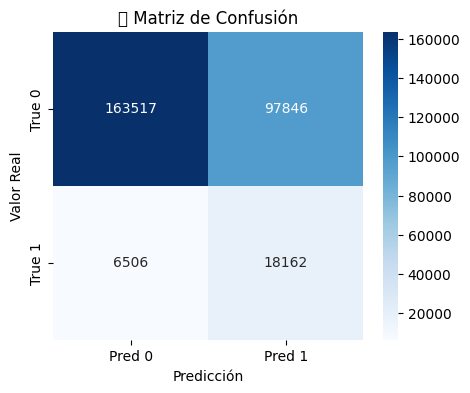

C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


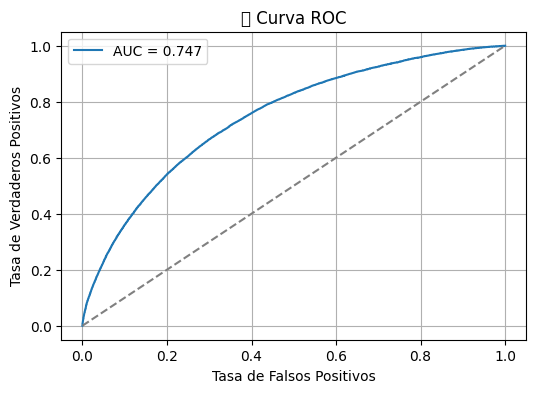

        🔍 RESUMEN DE DESEMPEÑO DEL MODELO         
⏱️  Tiempo de ejecución total: 96.35 segundos

📊 MÉTRICAS GLOBALES:
   - Accuracy:        0.635
   - Recall (Clase 1):0.736
   - Precision (Clase 1): 0.157
   - F1-score (Clase 1):  0.258
   - AUC:             0.747

📌 DESEMPEÑO POR CLASE:
  ▸ Clase 0
     - Precision: 0.962
     - Recall:    0.626
     - F1-score:  0.758
  ▸ Clase 1
     - Precision: 0.157
     - Recall:    0.736
     - F1-score:  0.258
🧮 MATRIZ DE CONFUSIÓN:
         Pred 0    Pred 1
True 0    163517     97846
True 1      6506     18162

🎯 RECALL Clase 1:
   - Entrenamiento: 0.7355
   - Prueba:        0.7363

🧪 Test de Wilcoxon (recall train vs test):
   - z = 288022993.5000
   - p-valor = 0.6961


In [165]:
X_val_preprocessed = preprocessor.transform(X_val)
y_pred = pipeline.named_steps['bcsca'].predict(X_val_preprocessed)
y_proba = pipeline.named_steps['bcsca'].predict_proba(X_val_preprocessed)[:, 1]  # Prob clase 1

tiempo = pipeline.named_steps['bcsca'].training_time_
imprimir_resultados_clasificacion(
    y_true=y_val,
    y_pred=y_pred,
    y_proba=y_proba,
    tiempo=tiempo,
    y_train_true=y_train,
    y_train_pred=pipeline.named_steps['bcsca'].predict(preprocessor.transform(X_train)),
    y_test_true=y_val,
    y_test_pred=y_pred
)
